In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def collect_data_and_plot(df, n_stores, n_warehouses, n_samples, test_mode, setting_name, is_profit=False):
    def run_main_run(row):
        try:
            cmd = [
                "/user/ml4723/.conda/envs/neural_inventory_control/bin/python",
                "main_run.py",
                test_mode, # test or test_on_dev
                setting_name,
                row['hyperparam_name'],
                row['path'] + '/model.pt',
                row['Architecture Class']
            ]
            env = {
                **os.environ,
                "MKL_THREADING_LAYER": "GNU",
                "MKL_SERVICE_FORCE_INTEL": "1"
            }
            subprocess.run(cmd, capture_output=True, text=True, check=True, env=env, cwd="/user/ml4723/Prj/NIC/")
        except subprocess.CalledProcessError as e:
            print(f"Error running main_run.py for path {row['path']}: {e}")
            print(f"Error output: {e.stderr}")
        except Exception as e:
            print(f"Unexpected error running main_run.py for path {row['path']}: {e}")

    def get_file_name(row):
        return f"results/{setting_name}/{n_stores}-{n_warehouses}/{row['Architecture Class']}.csv"
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        futures = []
        for _, row in df.iterrows():
            file_name = get_file_name(row)
            if os.path.exists(file_name):
                continue
            while len(futures) >= 8:
                done, not_done = concurrent.futures.wait(
                    futures, 
                    return_when=concurrent.futures.FIRST_COMPLETED
                )
                futures = list(not_done)
            futures.append(executor.submit(run_main_run, row))
        concurrent.futures.wait(futures)
    
    avg_s_underage = []
    avg_s_holding = []
    avg_w_holding = []
    avg_profit_or_cost = []
    w_holding_by_warehouse_all = []
    relevant_data_for_all = []
    for _, row in df.iterrows():
        file_name = get_file_name(row)
        data = pd.read_csv(file_name)
        batch_size = n_samples
        num_batches = n_samples // batch_size
        if test_mode == 'test_on_dev':
            num_steps = 50
            start_step = 16
        else:
            num_steps = 200
            start_step = 100
        
        relevant_indices = []
        for batch in range(num_batches):
            batch_start = batch * batch_size * num_steps
            step_start = batch_start + start_step * batch_size
            step_end = batch_start + num_steps * batch_size
            relevant_indices.extend(range(step_start, step_end))
        relevant_data = data.iloc[relevant_indices]
        
        s_underage = relevant_data['s_underage_costs'].sum()
        s_holding = relevant_data['s_holding_costs'].sum()
        
        # Split warehouse holding costs by warehouse
        w_holding_costs = []
        for i in range(n_warehouses):
            w_holding_costs.append(relevant_data[f'w_{i}_holding_costs'].sum())
        w_holding = sum(w_holding_costs)
        
        avg_s_underage.append(s_underage)
        avg_s_holding.append(s_holding)
        w_holding_by_warehouse_all.append(w_holding_costs)
        avg_w_holding.append(w_holding)
        
        if is_profit:
            # For profit: negate underage (revenue) and subtract costs
            profit = -s_underage - s_holding - w_holding
            avg_profit_or_cost.append(profit)
        else:
            # For loss: sum all costs
            cost = s_underage + s_holding + w_holding
            avg_profit_or_cost.append(cost)

        relevant_data_for_all.append(relevant_data)

    # Create a copy of the dataframe to avoid SettingWithCopyWarning
    df_copy = df.copy()
    df_copy['avg_s_underage'] = [-x if is_profit else x for x in avg_s_underage]
    df_copy['avg_s_holding'] = avg_s_holding
    df_copy['avg_w_holding'] = avg_w_holding
    
    # Add individual warehouse holding costs
    for i in range(n_warehouses):
        df_copy[f'w_{i}_holding'] = [x[i] for x in w_holding_by_warehouse_all]
        
    metric_name = 'avg_profit' if is_profit else 'avg_lost_sales'
    df_copy[metric_name] = avg_profit_or_cost
    df = df_copy

    # Calculate relative metric as percentage of best value
    if is_profit:
        best_value = df[metric_name].max()
        df['relative_metric'] = df[metric_name] / best_value * 100
    else:
        best_value = df[metric_name].min()
        df['relative_metric'] = df[metric_name] / best_value * 100

    plot_data = df.pivot(columns='Architecture Class', 
                        values=['relative_metric', 'avg_s_underage', 'avg_s_holding', 'avg_w_holding'] + 
                        [f'w_{i}_holding' for i in range(n_warehouses)])
    fig, axes = plt.subplots(3, 2, figsize=(20, 18))
    axes = axes.flatten()
    
    metric_title = 'Profit' if is_profit else 'Loss'
    titles = [f'{metric_title} (% of {"maximum" if is_profit else "minimum"})', 
              'Store Revenue(1e7)' if is_profit else 'Store Lost Sales(1e7)', 
              'Store Holding Cost(1e7)', 
              'Total Warehouse Holding Cost(1e7)', 
              'Individual Warehouse Holding Costs(1e7)']
    y_values = ['relative_metric', 'avg_s_underage', 'avg_s_holding', 'avg_w_holding']

    # Create a single legend at the top
    legend_lines = []
    legend_labels = []
    for arch in df['Architecture Class'].unique():
        legend_lines.append(plt.Line2D([0], [0], color=color_scheme[arch], 
                                     linestyle=linestyle_scheme[arch], marker='o', markersize=10))
        legend_labels.append(arch)
    
    fig.legend(legend_lines, legend_labels, loc='upper center', 
              bbox_to_anchor=(0.5, 0.98), ncol=len(legend_labels))

    for i, (ax, title, y_value) in enumerate(zip(axes[:-1], titles[:-1], y_values)):
        for arch in df['Architecture Class'].unique():
            if arch in plot_data[y_value].columns:
                plot_values = plot_data[y_value][arch].to_numpy()
                if y_value != 'relative_metric':
                    plot_values = plot_values / 1e7
                x_values = np.ones_like(plot_values)
                ax.plot(x_values, plot_values, marker='o', markersize=10,
                       color=color_scheme[arch], linestyle=linestyle_scheme[arch])
        
        ax.set_ylabel(title)
        ax.set_title(title)
        ax.grid(True)
        ax.set_xticks([])

    # Plot individual warehouse holding costs
    for arch in df['Architecture Class'].unique():
        for i in range(n_warehouses):
            if arch in plot_data[f'w_{i}_holding'].columns:
                plot_values = plot_data[f'w_{i}_holding'][arch].to_numpy() / 1e7
                x_values = np.ones_like(plot_values) * (i + 1)
                axes[-1].plot(x_values, plot_values, marker='o', markersize=10,
                            color=color_scheme[arch], linestyle=linestyle_scheme[arch])

    axes[-1].set_ylabel('Warehouse Holding Cost(1e7)')
    axes[-1].set_title('Individual Warehouse Holding Costs(1e7)')
    axes[-1].grid(True)
    axes[-1].set_xticks(range(1, n_warehouses + 1))
    axes[-1].set_xticklabels([f'W{i}' for i in range(n_warehouses)])

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()
    return df, relevant_data_for_all


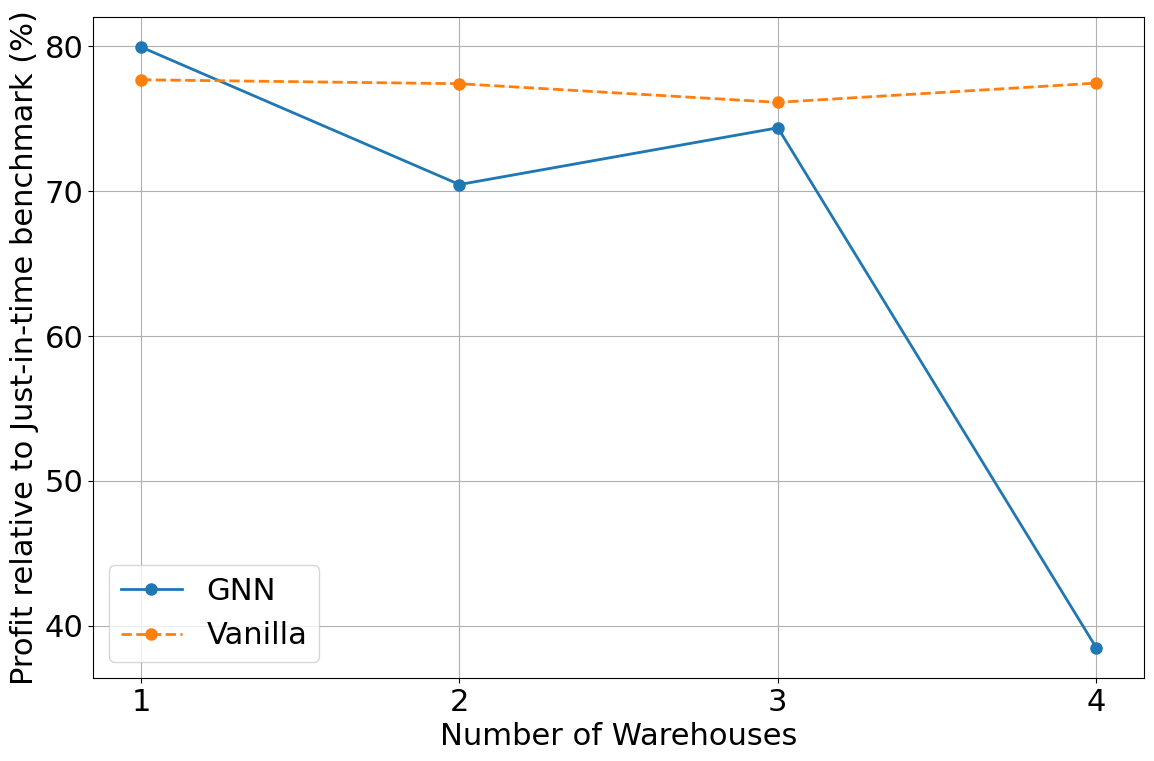

In [4]:
# Create vanilla results dataframe from the provided data
testset_names = ["n_warehouse_21_real_batch_test"]

results_interpretor = rri.RayResultsinterpreter()

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

# Define color scheme and line styles
color_scheme = {
    "GNN": "#1f77b4",    # Blue
    "GNN_fastest": "#2ca02c",  # Green
    "GNN_cheapest": "#d62728", # Red
    "Vanilla": "#ff7f0e",   # Orange
}

linestyle_scheme = {
    "GNN": "-",               # Solid
    "GNN_fastest": "-.",      # Dash-dot
    "GNN_cheapest": ":",      # Dotted
    "Vanilla": "--",      # Dashed
}

# Define configs for each architecture
architectures = {
    "GNN": "n_warehouse_21_{}_real_lost_demand",
    # "GNN_fastest": "n_warehouse_21_{}_real_lost_demand",
    # "GNN_cheapest": "n_warehouse_21_{}_real_lost_demand",
    "Vanilla": "n_warehouse_21_{}_real_lost_demand", 
    "Just-in-time": "n_warehouse_21_{}_real_lost_demand_just_in_time"
}

architectures_hyperparam_names = {
    "GNN": "GNN_real",
    "GNN_fastest": "GNN_real_fastest",
    "GNN_cheapest": "GNN_real_cheapest",
    "Vanilla": "data_driven_net_n_warehouses_real",
    "Just-in-time": "just_in_time_real"
}

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'

dfs = []
for arch_name, config_template in architectures.items():
    for n_warehouses in range(1, 5):  # 1 to 4 warehouses
        config = config_template.format(n_warehouses)
        path = f'/user/ml4723/Prj/NIC/ray_results/{testset_names[0]}/{architectures_hyperparam_names[arch_name]}'
        
        df = results_interpretor.make_table({1: path},
            {'config': [config]},
            default_condition_setter, custom_data_filler,
            sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by,
            test_loss_limit = 100)
        if df.empty:
            continue
        
        df.insert(2, 'Architecture Class', arch_name)
        df.insert(1, 'hyperparam_name', architectures_hyperparam_names[arch_name])
        df['n_warehouses'] = n_warehouses
        dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
stats_by_arch_and_warehouses = {}
for n_warehouses in range(1, 5):  # 1 to 4 warehouses
    warehouse_data = df[df['n_warehouses'] == n_warehouses].copy()
    if warehouse_data.empty:
        continue
        
    jit_loss = warehouse_data[warehouse_data['Architecture Class'] == 'Just-in-time']['Test Loss'].values[0]
    warehouse_data.loc[:, 'Profit %'] = (warehouse_data['Test Loss'] / jit_loss) * 100
    
    for arch in architectures.keys():
        if 'Just-in-time' in arch:
            continue
        key = arch
        if key not in stats_by_arch_and_warehouses:
            stats_by_arch_and_warehouses[key] = []
            
        arch_data = warehouse_data[warehouse_data['Architecture Class'] == arch]
        if not arch_data.empty:
            profits = arch_data['Profit %'].to_numpy()
            mean_profit = np.mean(profits)
            std_profit = np.std(profits)
            ci_95 = 1.96 * std_profit / np.sqrt(len(profits))
            stats_by_arch_and_warehouses[key].append({
                'n_warehouses': n_warehouses,
                'mean_profit': mean_profit,
                'ci_lower': mean_profit - ci_95,
                'ci_upper': mean_profit + ci_95
            })

# Create plot
FONTSIZE = 22
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': FONTSIZE})

# Plot lines
for arch, stats in stats_by_arch_and_warehouses.items():
    stats_df = pd.DataFrame(stats)
    if not stats_df.empty:
        warehouses_array = stats_df['n_warehouses'].to_numpy()
        mean_profit_array = stats_df['mean_profit'].to_numpy()
        ci_lower_array = stats_df['ci_lower'].to_numpy()
        ci_upper_array = stats_df['ci_upper'].to_numpy()
        
        plt.plot(warehouses_array, mean_profit_array,
                color=color_scheme[arch],
                linestyle=linestyle_scheme[arch],
                linewidth=2,
                marker='o',
                markersize=8,
                label=arch)
        
        plt.fill_between(warehouses_array,
                        ci_lower_array,
                        ci_upper_array,
                        color=color_scheme[arch],
                        alpha=0.1)

plt.xlabel('Number of Warehouses', fontsize=FONTSIZE)
plt.ylabel('Profit relative to Just-in-time benchmark (%)', fontsize=FONTSIZE)
plt.grid(True)
plt.legend(fontsize=FONTSIZE)

plt.xticks(range(1, 5), fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.tight_layout()
plt.show()

In [5]:
df

,# of stores,hyperparam_name,config,Architecture Class,Learning Rate,Train Loss,Dev Loss,Test Loss,# of runs,path,n_warehouses
0,1,GNN_real,n_warehouse_21_1_real_lost_demand,GNN,0.0010,-463.310118,-445.631519,-404.506299,1,/user/ml4723/Prj/NIC/ray_results/n_warehouse_2...,1
1,1,GNN_real,n_warehouse_21_2_real_lost_demand,GNN,0.0010,-409.308209,-392.604025,-356.468443,2,/user/ml4723/Prj/NIC/ray_results/n_warehouse_2...,2
2,1,GNN_real,n_warehouse_21_3_real_lost_demand,GNN,0.0100,-426.538644,-412.709908,-376.290029,2,/user/ml4723/Prj/NIC/ray_results/n_warehouse_2...,3
3,1,GNN_real,n_warehouse_21_4_real_lost_demand,GNN,0.0100,71369.561007,-204.055319,-194.647471,1,/user/ml4723/Prj/NIC/ray_results/n_warehouse_2...,4
4,1,data_driven_net_n_warehouses_real,n_warehouse_21_1_real_lost_demand,Vanilla,0.0001,-460.693817,-434.023778,-393.071807,4,/user/ml4723/Prj/NIC/ray_results/n_warehouse_2...,1
5,1,data_driven_net_n_warehouses_real,n_warehouse_21_2_real_lost_demand,Vanilla,0.0010,-464.672443,-429.564437,-391.696964,3,/user/ml4723/Prj/NIC/ray_results/n_warehouse_2...,2
6,1,data_driven_net_n_warehouses_real,n_warehouse_21_3_real_lost_demand,Vanilla,0.0001,-453.186357,-423.762598,-385.182571,3,/user/ml4723/Prj/NIC/ray_results/n_warehouse_2...,3
7,1,data_driven_net_n_warehouses_real,n_warehouse_21_4_real_lost_demand,Vanilla,0.0001,-457.140731,-430.230883,-391.907344,3,/user/ml4723/Prj/NIC/ray_results/n_warehouse_2...,4
8,1,just_in_time_real,n_warehouse_21_1_real_lost_demand_just_in_time,Just-in-time,NaN,-564.960142,-536.581192,-505.875976,3,/user/ml4723/Prj/NIC/ray_results/n_warehouse_2...,1
9,1,just_in_time_real,n_warehouse_21_2_real_lost_demand_just_in_time,Just-in-time,NaN,-564.960117,-536.581192,-505.875976,3,/user/ml4723/Prj/NIC/ray_results/n_warehouse_2...,2


In [ ]:
df_analysis = df[df['n_warehouses'] == 3]

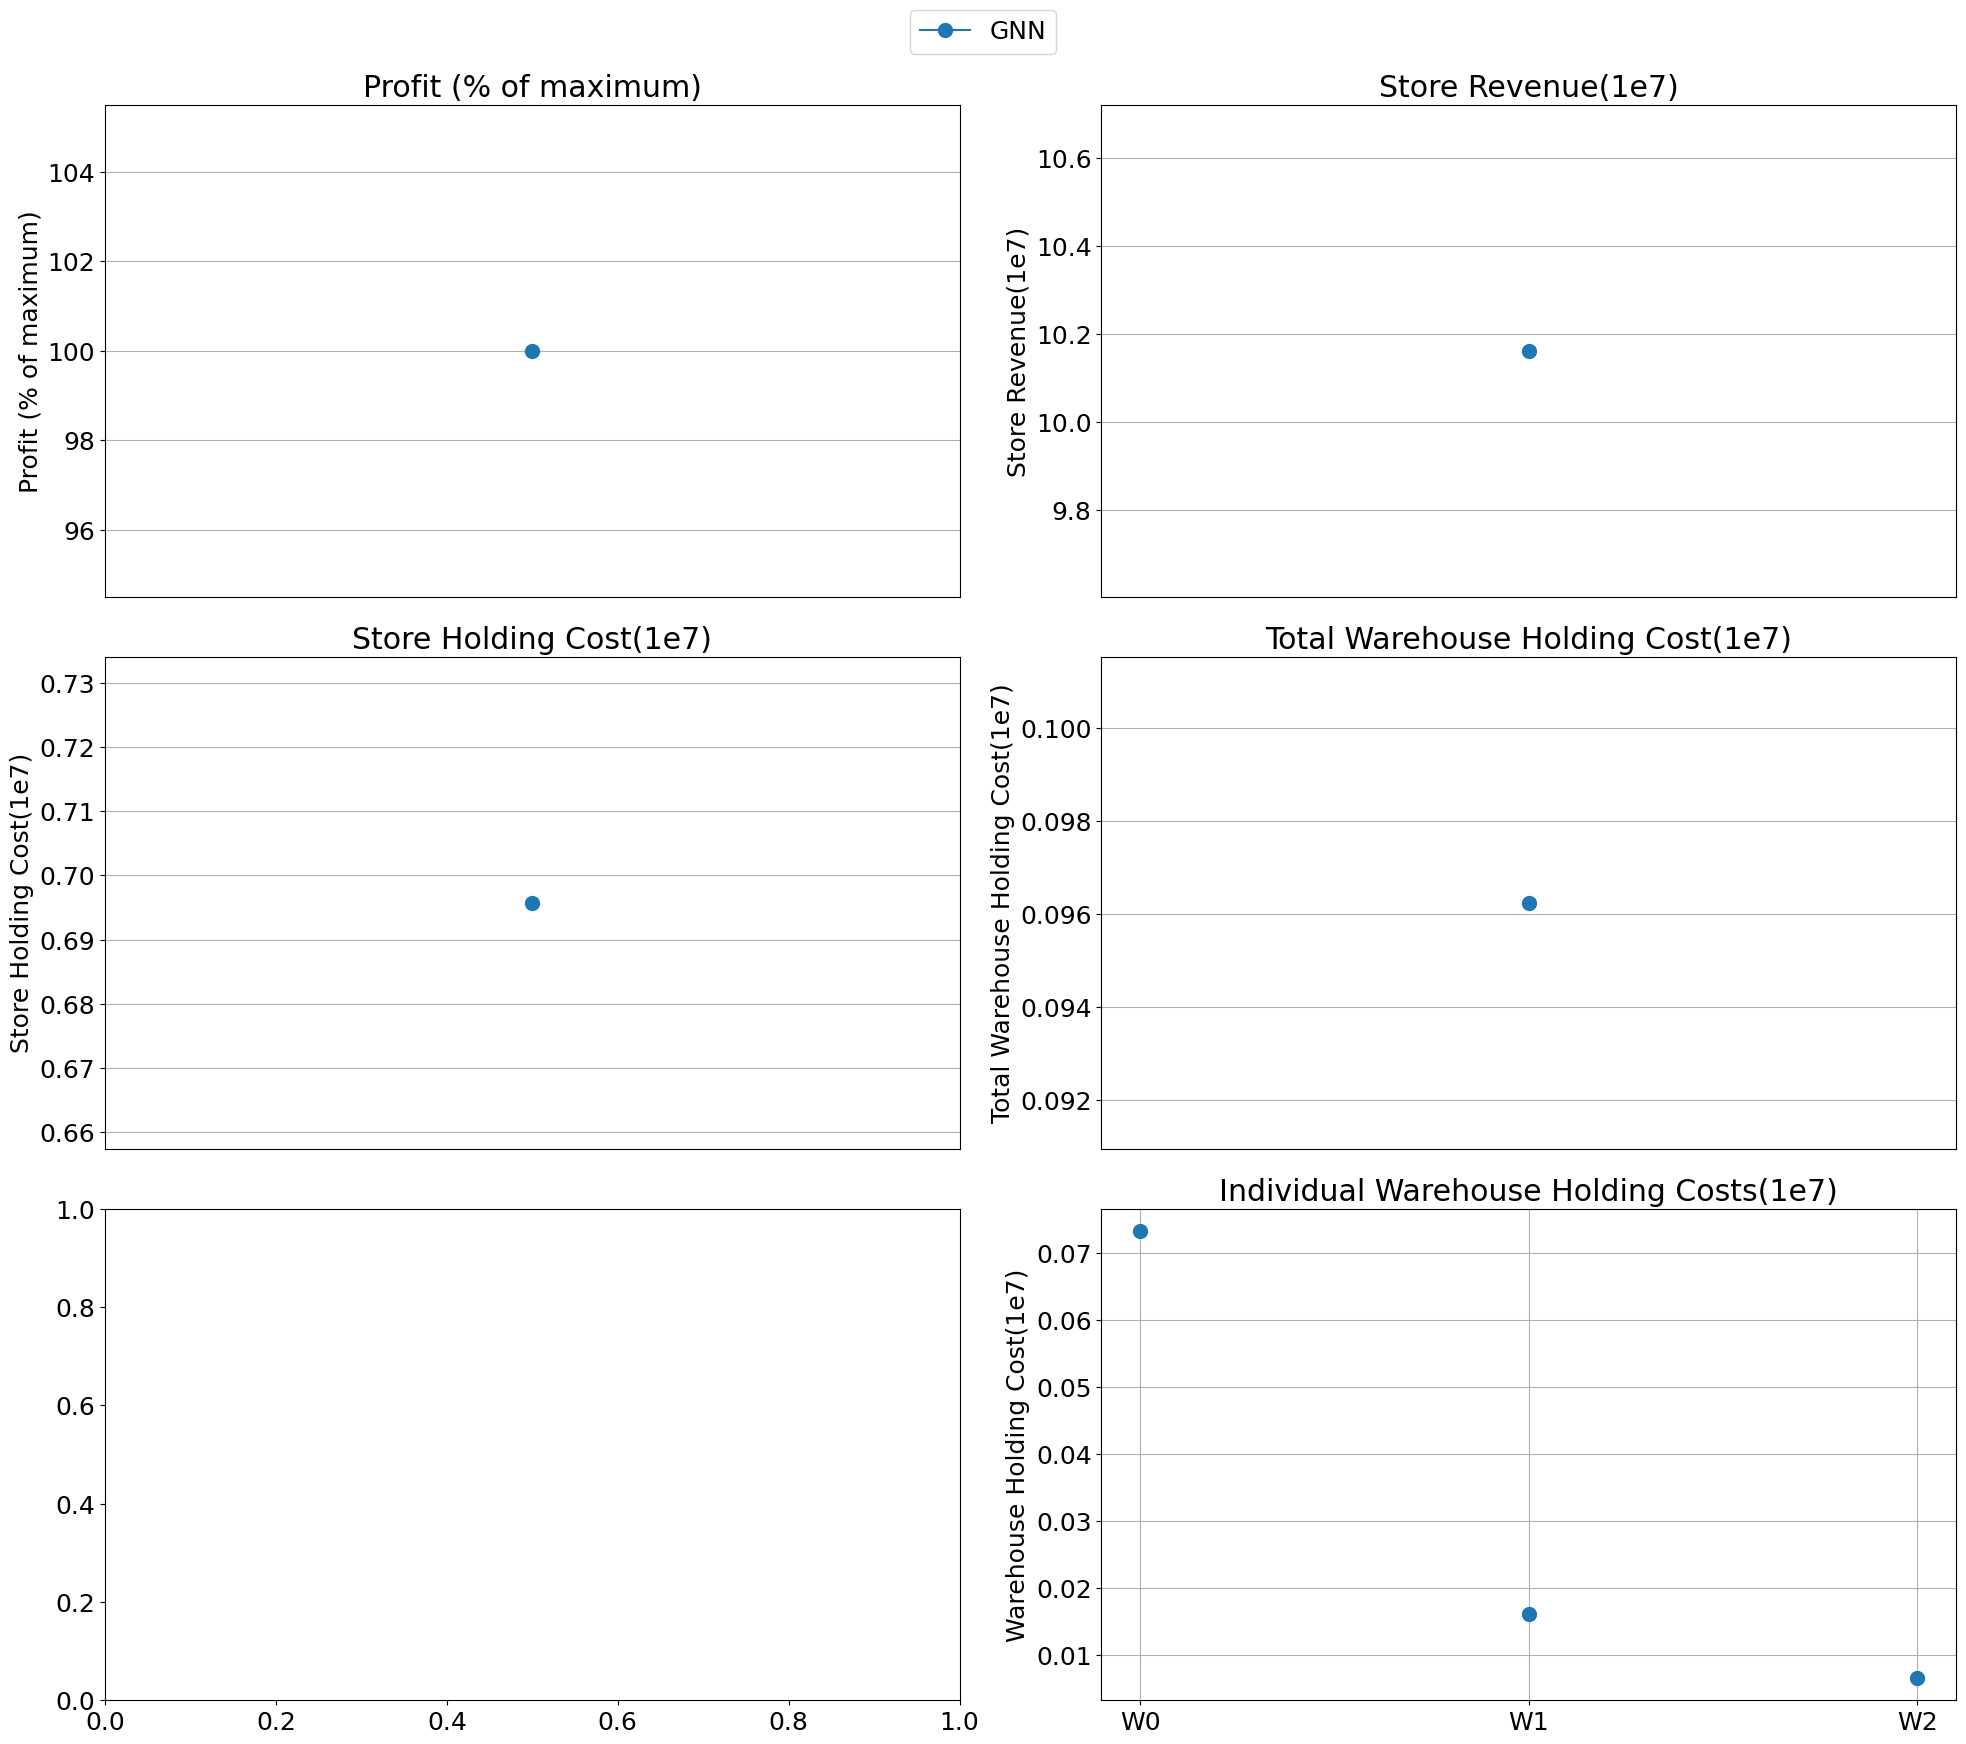

In [38]:
df_analysis = df[df['Architecture Class'] != 'Just-in-time']
df_analysis = df[df['Architecture Class'] != 'Data Driven']
df, data = collect_data_and_plot(df_analysis, 21, 3, 288, "test", "n_warehouse_21_3_real_lost_demand", True)

In [41]:
data[0]

,s_0_demand,s_0_underage_costs,s_0_holding_costs,s_0_inventory_0,s_0_inventory_1,s_0_inventory_2,s_0_inventory_3,s_0_w_0_order,s_0_w_1_order,s_0_w_2_order,...,w_1_inventory,w_2_inventory,s_underage_costs,s_holding_costs,w_0_holding_costs,w_0_edge_costs,w_1_holding_costs,w_1_edge_costs,w_2_holding_costs,w_2_edge_costs
4608,63.0,7.961858,1.085614,52.529007,3.835898e+01,63.147090,2.557476e-04,48.427464,4.949306e-05,3.267568e-07,...,95.827500,44.291930,-4821.8975,259.24777,2.440979,335.79690,2.249414,135.30594,0.050684,43.785095
4609,180.0,6.704189,0.726056,136.598340,1.489789e+02,150.366790,8.729650e-11,166.802460,4.150296e+00,4.366236e+00,...,77.075180,118.099920,-8709.6875,288.42834,0.000000,654.40550,0.000000,115.61276,1.531856,102.781360
4610,177.0,5.954967,1.139918,201.277970,2.127056e+02,189.360760,7.589313e-15,217.564040,1.560170e+01,3.193485e-07,...,357.140720,196.400700,-16418.9160,903.11993,48.407130,1132.30770,52.489300,338.87620,1.021344,186.187260
4611,30.0,6.056287,0.797073,12.062489,2.110218e+01,23.164259,2.638802e-01,21.905214,1.968505e-03,4.524892e-03,...,60.121773,34.053650,-2576.2615,261.04132,25.250380,147.46266,0.000003,90.18265,2.381115,10.242504
4612,46.0,7.517613,1.068346,54.710377,3.914319e+01,55.194748,1.033755e-01,37.538727,5.762029e+00,7.225461e-02,...,112.125720,20.772865,-5080.4766,38.98687,0.000000,234.85220,0.000000,168.18857,0.000000,20.772865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14395,380.0,5.893615,1.231551,508.917880,2.519735e+02,171.678070,1.732281e-22,212.401000,2.212376e-18,1.472122e-19,...,312.084300,350.084320,-28510.2090,834.72186,172.294240,1791.70090,0.000000,468.12643,7.552710,274.557220
14396,35.0,5.963710,1.270233,282.647900,2.171047e-07,15.506066,2.579283e-08,28.245792,2.334279e-07,1.445095e-08,...,76.836500,93.148050,-3408.4482,1478.51210,231.539920,223.37128,18.638601,45.36000,7.820747,14.940578
14397,92.0,8.346569,1.124895,259.062740,1.229520e+02,103.714516,1.271048e-15,141.712920,1.686956e-07,1.843698e-10,...,180.511060,121.290650,-7565.2590,929.85800,161.854980,557.34094,37.907726,128.61263,6.465021,56.640438
14398,118.0,5.675506,1.202372,106.516100,1.273091e+02,122.879425,6.224871e-06,123.925020,9.846151e-01,2.059302e-05,...,332.012900,91.224090,-11010.7850,657.88586,0.000024,718.44430,1.316272,493.08334,4.809060,43.133490
